In [1]:
# Import necessary libraries

import numpy as np   # python library for numerical operations
import pandas as pd   # for dealing with multi-dimensional dataframes
import matplotlib.pyplot as plt   # for plotting graphs and visualizations
import seaborn as sns      # for plotting graphs and visualizations
from sklearn import preprocessing   # For data preprocessing operations
import scipy.stats as stats              # For statistical models and operations
from sklearn.model_selection import train_test_split   # To split the dataset into train and test
from collections import Counter     # For counting samples and such operations
from imblearn.over_sampling import SMOTE    # SMOTE algorithm for data resampling and de-skew
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report   # evaluation metrics for models
from sklearn import metrics  # evaluation metrics for models
import joblib   # The joblib library for pipilined jobs

### Frame the ML problem

#### It is a Binary Classification Problem
#### Two classes
#### Label = RainTomorrow
#### Classes = Yes or No   (RainTomorrow - Yes or No)
#### Input some features such as RainToday, Sunshine, MaxTemp, Rainfall,etc and ML model to predict RainTomorrow

In [77]:
# Read the dataset


data = pd.read_csv("weatherAUS.csv")    # Read the dataset
pd.set_option("display.max_columns", None)   # Display all the columns

In [78]:
data.head()    # See the samples

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [79]:
data.shape    # check the numbers

(145460, 23)

#### It shows that there are 145460 samples/rows and 23 features/columns in the dataset

### Data analysis

In [80]:
data.columns   # See the column names

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [81]:
# Count the number of numerical features - features that have numerical entries
numerical_feature = [feature for feature in data.columns if data[feature].dtypes != 'O'] 


print("Numerical Features Count = ", len(numerical_feature))

Numerical Features Count =  16


In [82]:
# Count the number of discrete numerical features in the 16 numerical features
discrete_feature=[feature for feature in numerical_feature if len(data[feature].unique())<25]


print("Discrete numerical feature Count =", len(discrete_feature))

Discrete numerical feature Count = 2


In [83]:
# Count the number of continous numerical features in the 16 numerical features
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]


print("Continuous numerical feature Count = ", len(continuous_feature))

Continuous numerical feature Count =  14


In [84]:
# Count the number of numerical features - features that have vategiry type entries
categorical_feature = [feature for feature in data.columns if feature not in numerical_feature]


print("Categorical feature Count = ", len(categorical_feature))

Categorical feature Count =  7


##### So out of 16 total features, 

##### 7 are categorical and 16 are numerical

##### In the 16 numerical features, 14 are continous and 2 are descrete

In [85]:
# Check the number of missing values in the features

data.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [86]:
# There are a lots of missing values in many features/columns
# Check the percentage of missing values

data.isnull().sum()*100/len(data)

Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64

#### Evaporation, Sunshine, Cloud9am, and Cloud3pm have the most number of missing values that need to be addressed

#### Data Imputation: Fill the missing values in some way


In [87]:
# Define a function to do 'Randome Imputation'
# Randomely resample the available samples to fill the missing values in the feature

def randomsampleimputation(dataset, variable):
    dataset[variable]=dataset[variable]
    random_sample=dataset[variable].dropna().sample(dataset[variable].isnull().sum(),random_state=0)
    random_sample.index=dataset[dataset[variable].isnull()].index
    dataset.loc[dataset[variable].isnull(),variable]=random_sample # Replace the null values/missing values with random samples

In [88]:
# Apply the finction on the dataset

randomsampleimputation(data, "Cloud9am")
randomsampleimputation(data, "Cloud3pm")
randomsampleimputation(data, "Evaporation")
randomsampleimputation(data, "Sunshine")

In [89]:
# Now check the percentage of missing values again
data.isnull().sum()*100/len(data)

Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation       0.000000
Sunshine          0.000000
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am          0.000000
Cloud3pm          0.000000
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64

#### For the four features, the missing percentage is 0% now

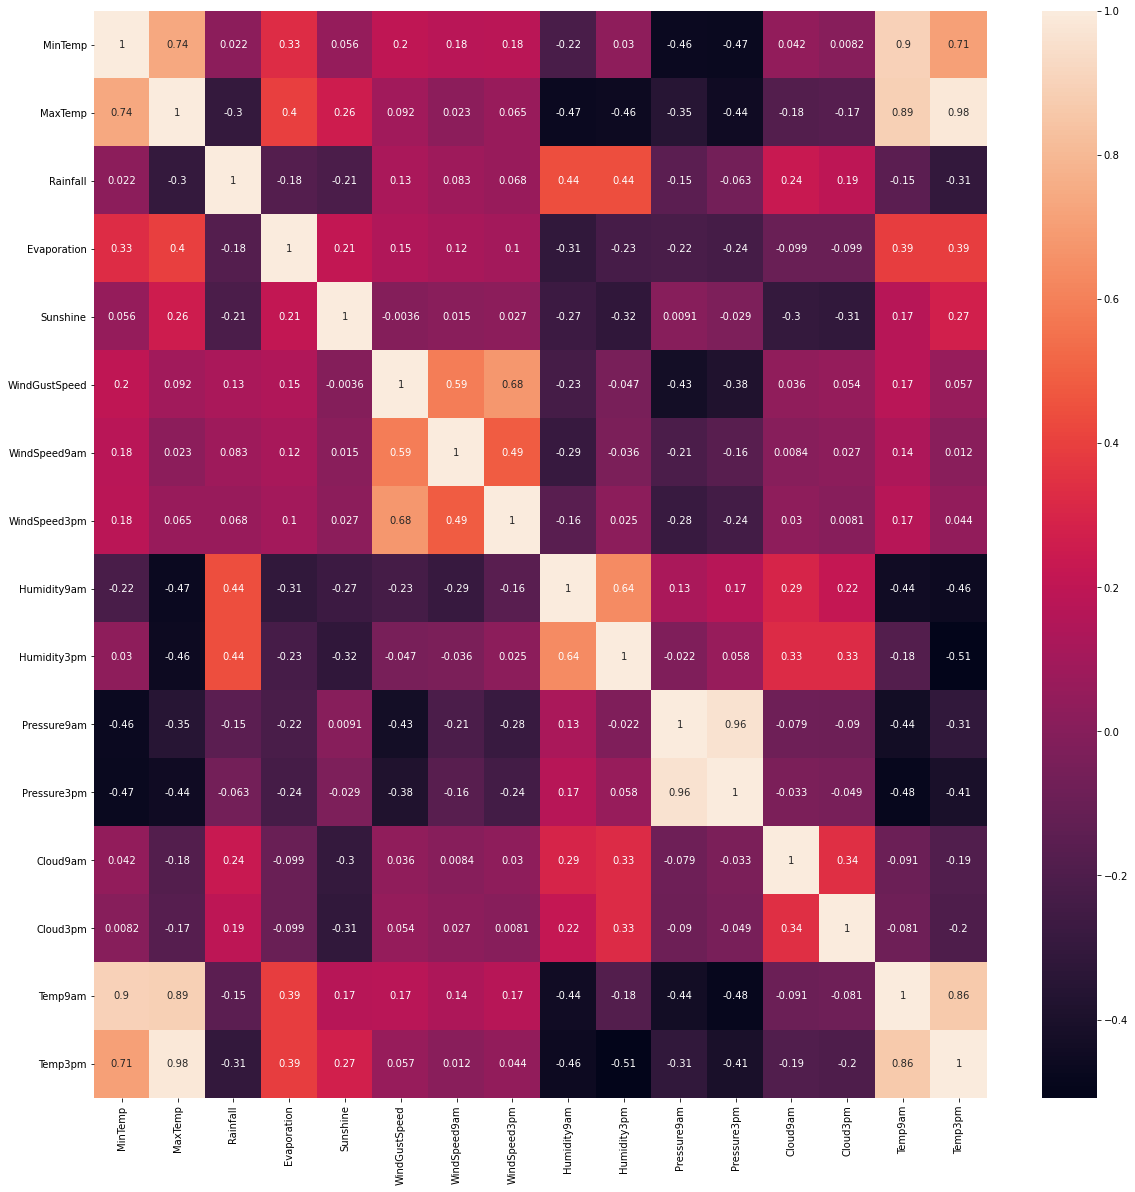

In [55]:
# Plot the correlation map to see the correlation between features

corrmat = data.corr(method = "spearman")
plt.figure(figsize=(20,20))

# plot the heat map
g=sns.heatmap(corrmat,annot=True)

#### There is no much issue with the correlation as the heatmap has high diagonal values

#### Now analyse the continous  feature to know its distribution.
#### Gaussian/Normal Distribution of continous feature is preferred because the ML model can learn such distributions better.

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


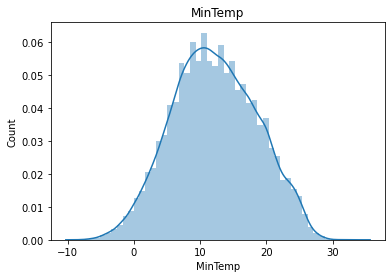

<Figure size 1080x1080 with 0 Axes>

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


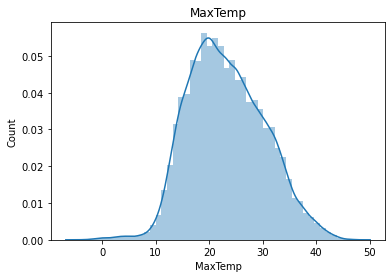

<Figure size 1080x1080 with 0 Axes>

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


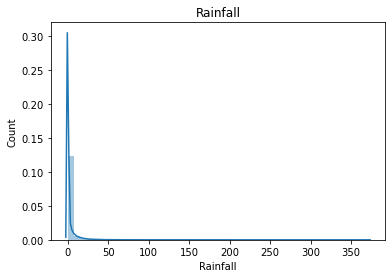

<Figure size 1080x1080 with 0 Axes>

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


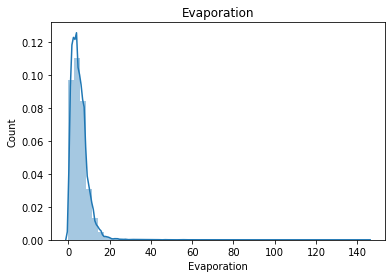

<Figure size 1080x1080 with 0 Axes>

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


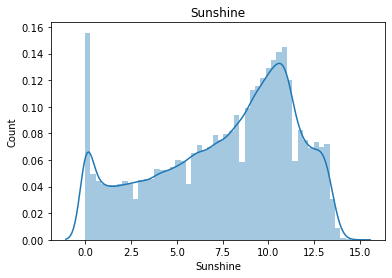

<Figure size 1080x1080 with 0 Axes>

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


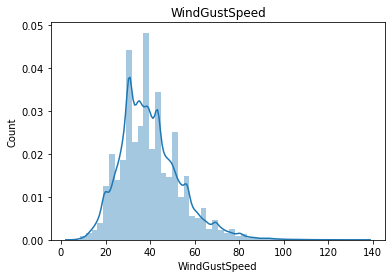

<Figure size 1080x1080 with 0 Axes>

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


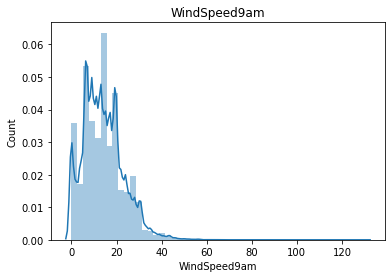

<Figure size 1080x1080 with 0 Axes>

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


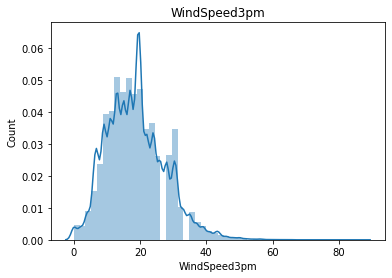

<Figure size 1080x1080 with 0 Axes>

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


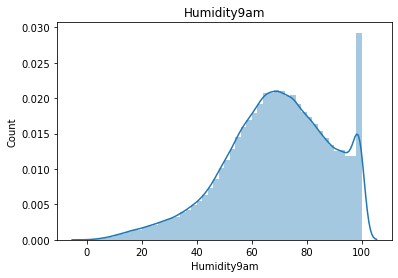

<Figure size 1080x1080 with 0 Axes>

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


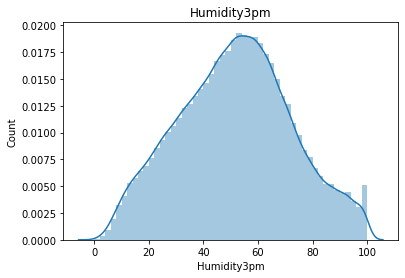

<Figure size 1080x1080 with 0 Axes>

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


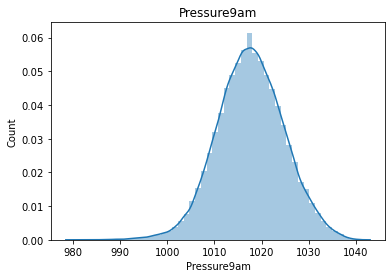

<Figure size 1080x1080 with 0 Axes>

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


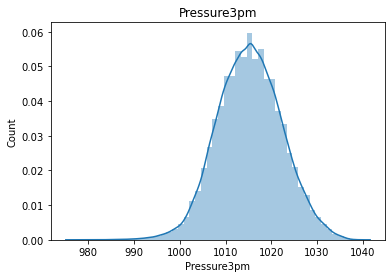

<Figure size 1080x1080 with 0 Axes>

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


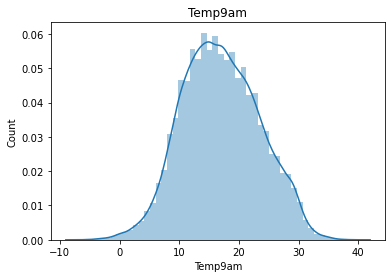

<Figure size 1080x1080 with 0 Axes>

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


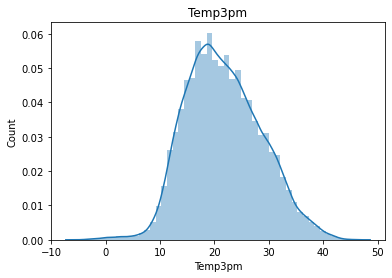

<Figure size 1080x1080 with 0 Axes>

In [56]:
#Plot the distribution of all the continuos features

for feature in continuous_feature:
    datas=data.copy()
    sns.distplot(data[feature])
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.figure(figsize=(15,15))
    plt.show()

#### Most of teh features have teh Gaussian distribution/the bell curve

### Then we have to fill the remianing missing values

#### Fill the missing values in the continous feature with the median of that feature

In [90]:
for feature in continuous_feature:
    if(data[feature].isnull().sum()*100/len(data))>0:   # If percentage of missing/null values greater than 0
        data[feature] = data[feature].fillna(data[feature].median())  # Fill it with the median of the feature

In [91]:
# Now check the percentage of missing values again
data.isnull().sum()*100/len(data)

Date             0.000000
Location         0.000000
MinTemp          0.000000
MaxTemp          0.000000
Rainfall         0.000000
Evaporation      0.000000
Sunshine         0.000000
WindGustDir      7.098859
WindGustSpeed    0.000000
WindDir9am       7.263853
WindDir3pm       2.906641
WindSpeed9am     0.000000
WindSpeed3pm     0.000000
Humidity9am      0.000000
Humidity3pm      0.000000
Pressure9am      0.000000
Pressure3pm      0.000000
Cloud9am         0.000000
Cloud3pm         0.000000
Temp9am          0.000000
Temp3pm          0.000000
RainToday        2.241853
RainTomorrow     2.245978
dtype: float64

#### Now fill the missing values in RainToday and RainTomorrow features

In [92]:
data["RainToday"] = pd.get_dummies(data["RainToday"], drop_first = True)  
# Fill and replace categorical features (Yes and No) with numbers (0 and 1)

In [93]:
data["RainTomorrow"] = pd.get_dummies(data["RainTomorrow"], drop_first = True)
# Fill and replace categorical features (Yes and No) with numbers (0 and 1)

In [94]:
# Now check the percentage of missing values again
data.isnull().sum()*100/len(data)

Date             0.000000
Location         0.000000
MinTemp          0.000000
MaxTemp          0.000000
Rainfall         0.000000
Evaporation      0.000000
Sunshine         0.000000
WindGustDir      7.098859
WindGustSpeed    0.000000
WindDir9am       7.263853
WindDir3pm       2.906641
WindSpeed9am     0.000000
WindSpeed3pm     0.000000
Humidity9am      0.000000
Humidity3pm      0.000000
Pressure9am      0.000000
Pressure3pm      0.000000
Cloud9am         0.000000
Cloud3pm         0.000000
Temp9am          0.000000
Temp3pm          0.000000
RainToday        0.000000
RainTomorrow     0.000000
dtype: float64

Remaining three features with missing values are 

1. WindGustDir

2. WindDir9am  

3. WindDir3pm

They are categorical features with values such as 'NE', 'SE', 'ESE', 'ENE', etc

We have to convert them into numbers first

In [95]:
windgustdir = {'NNW':0, 'NW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 'SW':9, 'SSE':10,
       'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15}

data["WindGustDir"] = data["WindGustDir"].map(windgustdir) # Replace the words with the numbers in order

In [96]:
winddir9am = {'NNW':0, 'N':1, 'NW':2, 'NNE':3, 'WNW':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 'NE':9, 'S':10,
       'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15}


data["WindDir9am"] = data["WindDir9am"].map(winddir9am)  # Replace the words with the numbers in order

In [97]:
winddir3pm = {'NW':0, 'NNW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 'SW':9, 'SE':10,
       'NE':11, 'SSE':12, 'ENE':13, 'E':14, 'ESE':15}

data["WindDir3pm"] = data["WindDir3pm"].map(winddir3pm) # Replace the words with the numbers in order

In [101]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0
1,2008-12-02,Albury,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0
2,2008-12-03,Albury,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0
3,2008-12-04,Albury,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0
4,2008-12-05,Albury,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0


##### Now fill the missing values

In [104]:
# Fill the missing values with mode/the most frequently used value in the feature (first values in the value_counts())

data["WindGustDir"] = data["WindGustDir"].fillna(data["WindGustDir"].value_counts().index[0])

In [105]:
# Fill the missing values with mode/the most frequently used value in the feature

data["WindDir9am"] = data["WindDir9am"].fillna(data["WindDir9am"].value_counts().index[0])

In [106]:
# Fill the missing values with mode/the most frequently used value in the feature

data["WindDir3pm"] = data["WindDir3pm"].fillna(data["WindDir3pm"].value_counts().index[0])

In [107]:
# Now check the percentage of missing values again
data.isnull().sum()*100/len(data)

Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
dtype: float64

##### All the missing values are filled now

In [108]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0
1,2008-12-02,Albury,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0
2,2008-12-03,Albury,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0
3,2008-12-04,Albury,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0
4,2008-12-05,Albury,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0


##### need to convert 'Location' into numbers

In [109]:
df1 = data.groupby(["Location"])["RainTomorrow"].value_counts().sort_values().unstack()

# Group Location based on RainTomorrow feature

In [110]:
df1

RainTomorrow,0,1
Location,,
Adelaide,2505,688
Albany,2138,902
Albury,2422,618
AliceSprings,2796,244
BadgerysCreek,2426,583
Ballarat,2259,781
Bendigo,2478,562
Brisbane,2484,709
Cairns,2090,950


0 is for No and 1 for Yes

In [111]:
df1[1].sort_values(ascending = False)  # Sort the 0 column or the Yes column in descending order to see Location where the RainTomorrow is highest

Location
Portland            1095
Cairns               950
Walpole              949
Dartmoor             922
MountGambier         920
NorfolkIsland        919
Albany               902
Witchcliffe          879
CoffsHarbour         869
Sydney               865
Darwin               852
MountGinini          819
NorahHead            808
Ballarat             781
GoldCoast            775
SydneyAirport        774
Hobart               761
Watsonia             738
Newcastle            731
Wollongong           713
Brisbane             709
Williamtown          700
Launceston           699
Adelaide             688
MelbourneAirport     653
Perth                645
Sale                 643
Melbourne            636
Canberra             629
Albury               618
Penrith              595
Nuriootpa            592
BadgerysCreek        583
Tuggeranong          568
PerthAirport         567
Bendigo              562
Richmond             560
WaggaWagga           536
Townsville           519
PearceRAAF      

#### Portland has highest number of Yes in RainTomorrow values

In [112]:
# Print the Location names in the order
df1[1].sort_values(ascending = False).index

Index(['Portland', 'Cairns', 'Walpole', 'Dartmoor', 'MountGambier',
       'NorfolkIsland', 'Albany', 'Witchcliffe', 'CoffsHarbour', 'Sydney',
       'Darwin', 'MountGinini', 'NorahHead', 'Ballarat', 'GoldCoast',
       'SydneyAirport', 'Hobart', 'Watsonia', 'Newcastle', 'Wollongong',
       'Brisbane', 'Williamtown', 'Launceston', 'Adelaide', 'MelbourneAirport',
       'Perth', 'Sale', 'Melbourne', 'Canberra', 'Albury', 'Penrith',
       'Nuriootpa', 'BadgerysCreek', 'Tuggeranong', 'PerthAirport', 'Bendigo',
       'Richmond', 'WaggaWagga', 'Townsville', 'PearceRAAF', 'SalmonGums',
       'Moree', 'Cobar', 'Mildura', 'Katherine', 'AliceSprings', 'Nhil',
       'Woomera', 'Uluru'],
      dtype='object', name='Location')

In [113]:
# Total number of locations


len(df1[1].sort_values(ascending = False).index)

49

##### Now replace the location names with numbers in order

In [114]:
location = {'Portland':1, 'Cairns':2, 'Walpole':3, 'Dartmoor':4, 'MountGambier':5,
       'NorfolkIsland':6, 'Albany':7, 'Witchcliffe':8, 'CoffsHarbour':9, 'Sydney':10,
       'Darwin':11, 'MountGinini':12, 'NorahHead':13, 'Ballarat':14, 'GoldCoast':15,
       'SydneyAirport':16, 'Hobart':17, 'Watsonia':18, 'Newcastle':19, 'Wollongong':20,
       'Brisbane':21, 'Williamtown':22, 'Launceston':23, 'Adelaide':24, 'MelbourneAirport':25,
       'Perth':26, 'Sale':27, 'Melbourne':28, 'Canberra':29, 'Albury':30, 'Penrith':31,
       'Nuriootpa':32, 'BadgerysCreek':33, 'Tuggeranong':34, 'PerthAirport':35, 'Bendigo':36,
       'Richmond':37, 'WaggaWagga':38, 'Townsville':39, 'PearceRAAF':40, 'SalmonGums':41,
       'Moree':42, 'Cobar':43, 'Mildura':44, 'Katherine':45, 'AliceSprings':46, 'Nhil':47,
       'Woomera':48, 'Uluru':49}



data["Location"] = data["Location"].map(location) # Replace with numbers

In [115]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0
1,2008-12-02,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0
2,2008-12-03,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0
3,2008-12-04,30,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0
4,2008-12-05,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0


#### Create more features from the 'Date' feature

In [117]:
# Convert the format of the Date
data["Date"] = pd.to_datetime(data["Date"], format = "%Y-%m-%dT", errors = "coerce")


data["Date_month"] = data["Date"].dt.month  # New feature - month
data["Date_day"] = data["Date"].dt.day     # New feature - day

In [118]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,2008-12-01,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0,12,1
1,2008-12-02,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0,12,2
2,2008-12-03,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0,12,3
3,2008-12-04,30,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0,12,4
4,2008-12-05,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,12,5


In [119]:
data.Date_month

0         12
1         12
2         12
3         12
4         12
          ..
145455     6
145456     6
145457     6
145458     6
145459     6
Name: Date_month, Length: 145460, dtype: int64

In [120]:
data.Date_day

0          1
1          2
2          3
3          4
4          5
          ..
145455    21
145456    22
145457    23
145458    24
145459    25
Name: Date_day, Length: 145460, dtype: int64

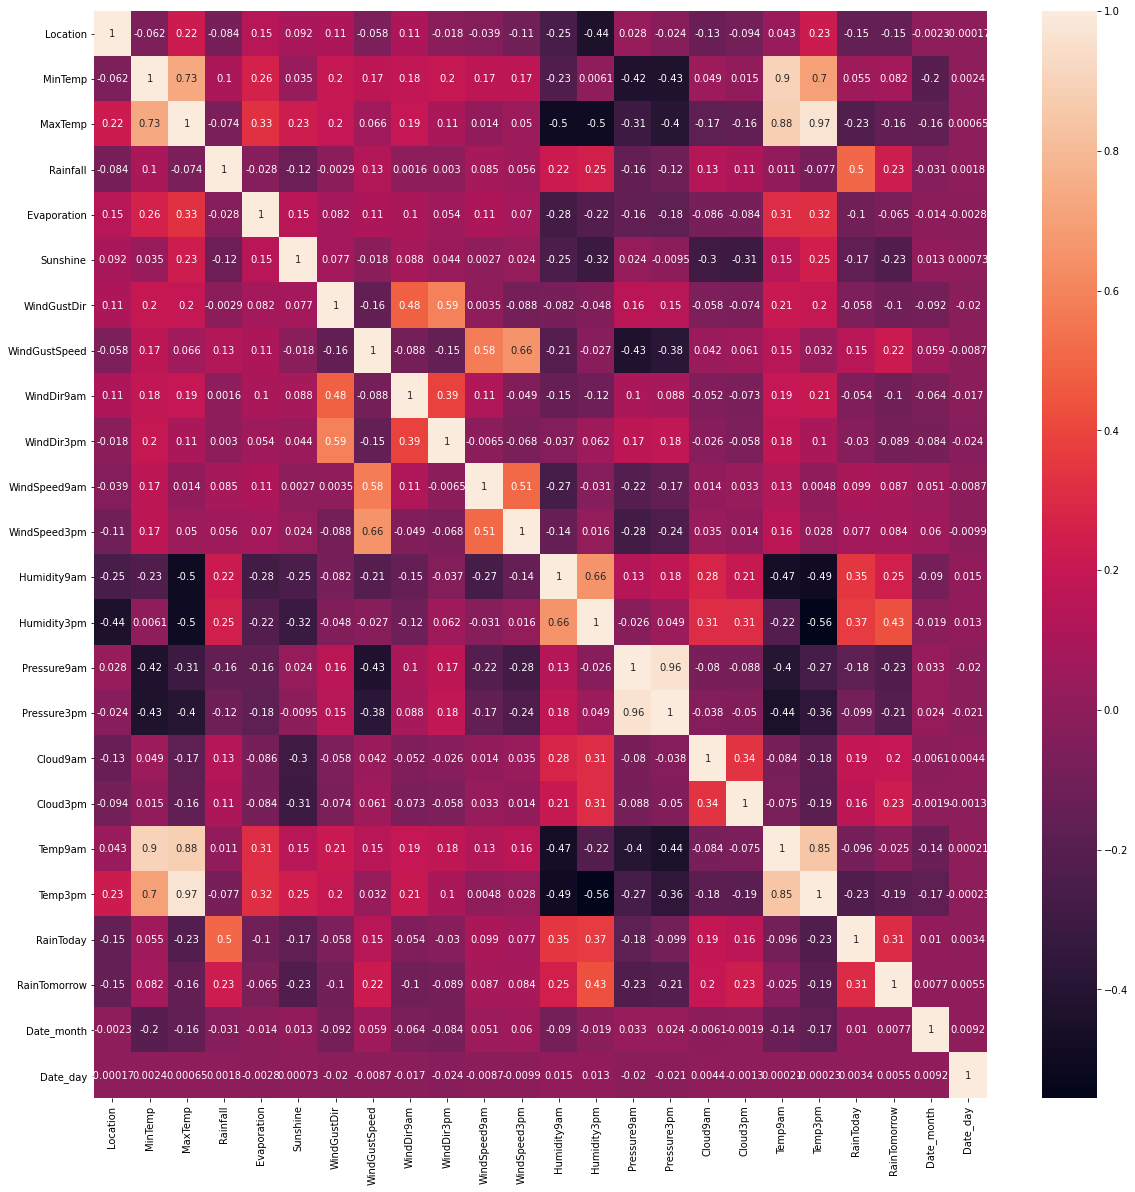

In [121]:
# Now plot the correlation map again

corrmat = data.corr()
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

#### Check the number of Yes (1) and No (0) in RainTomorrow label

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

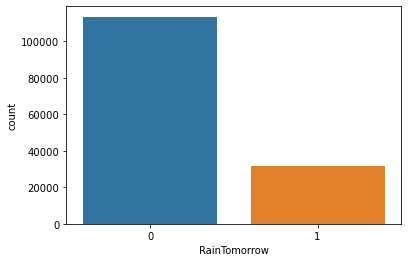

In [122]:
sns.countplot(data["RainTomorrow"])

In [123]:
len(data.RainTomorrow)

145460

In [124]:
data.RainTomorrow.value_counts()

0    113583
1     31877
Name: RainTomorrow, dtype: int64

#### Out of the 145460 samples, 113583 are in class 0 (No RainTomorrow) and 31877 are in class 1 (Yes RainTomorrow)

#### Now plot the box plot of the continous features
#### To see if there are any outliers in that feature
#### outliers: values lie beyond the limit of the box or limit of the distribution

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1080x1080 with 0 Axes>

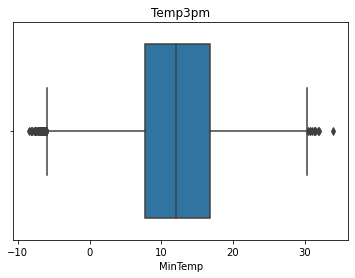

<Figure size 1080x1080 with 0 Axes>

In [126]:
datas=data.copy()
sns.boxplot(datas['MinTemp'])
plt.title(feature)
plt.figure(figsize=(15,15))

#### We can see few values lie beyond the right and left limit of the box

#### Plot the Box plot of all the continous features

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

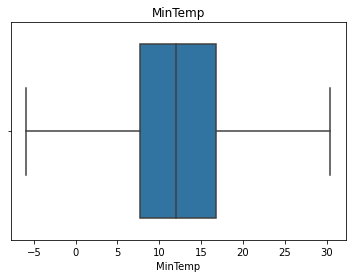

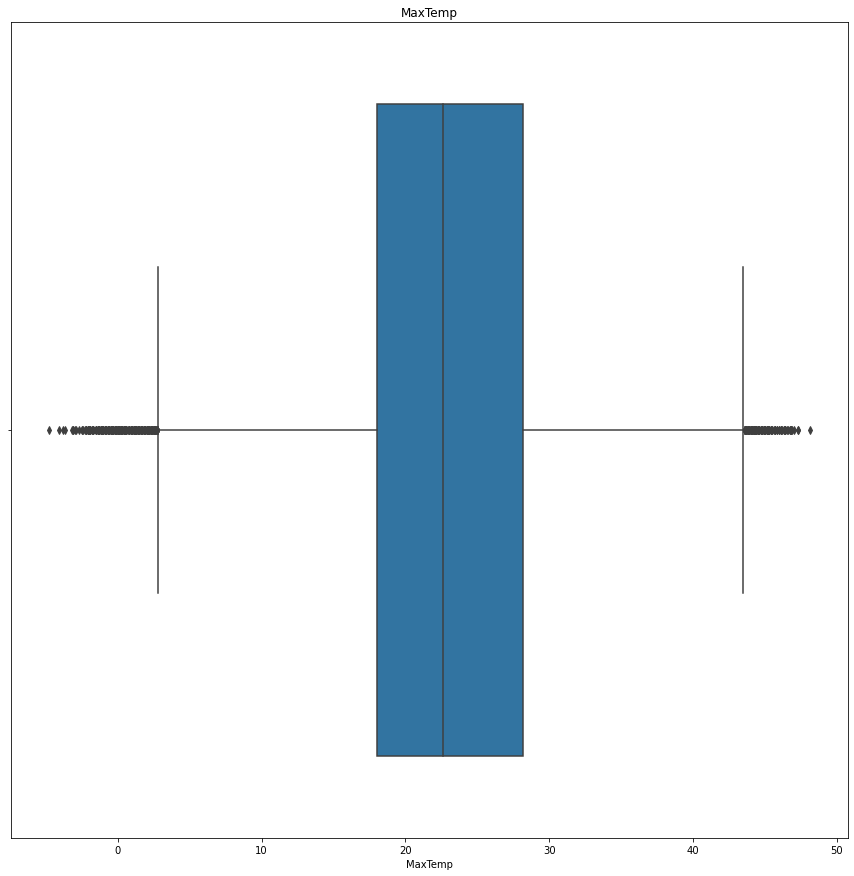

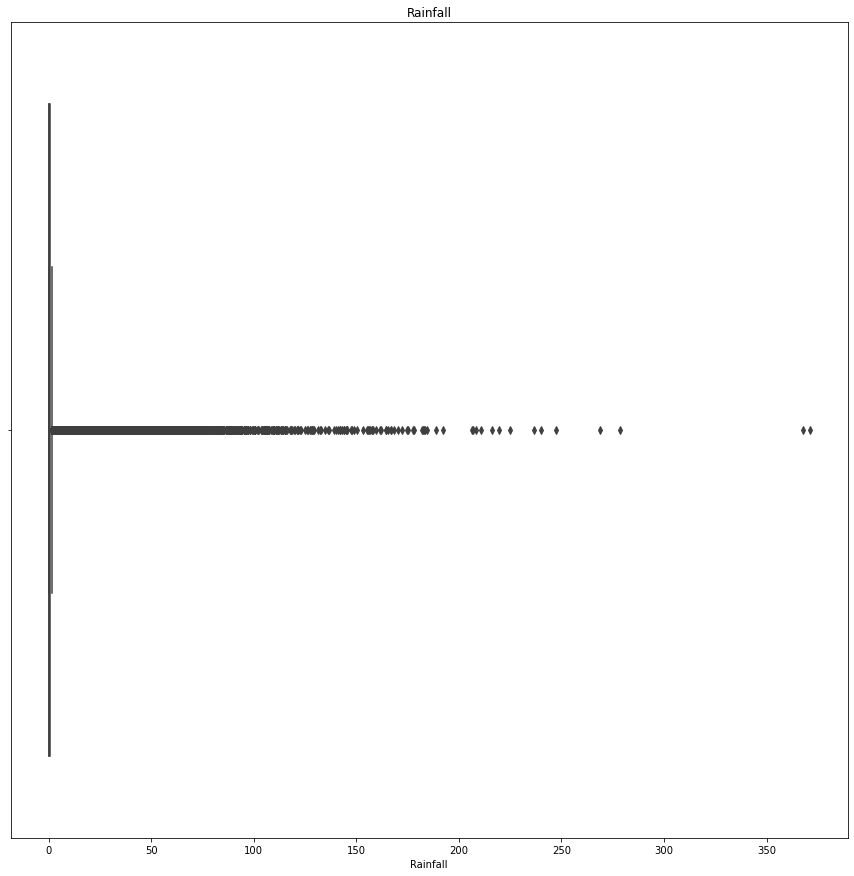

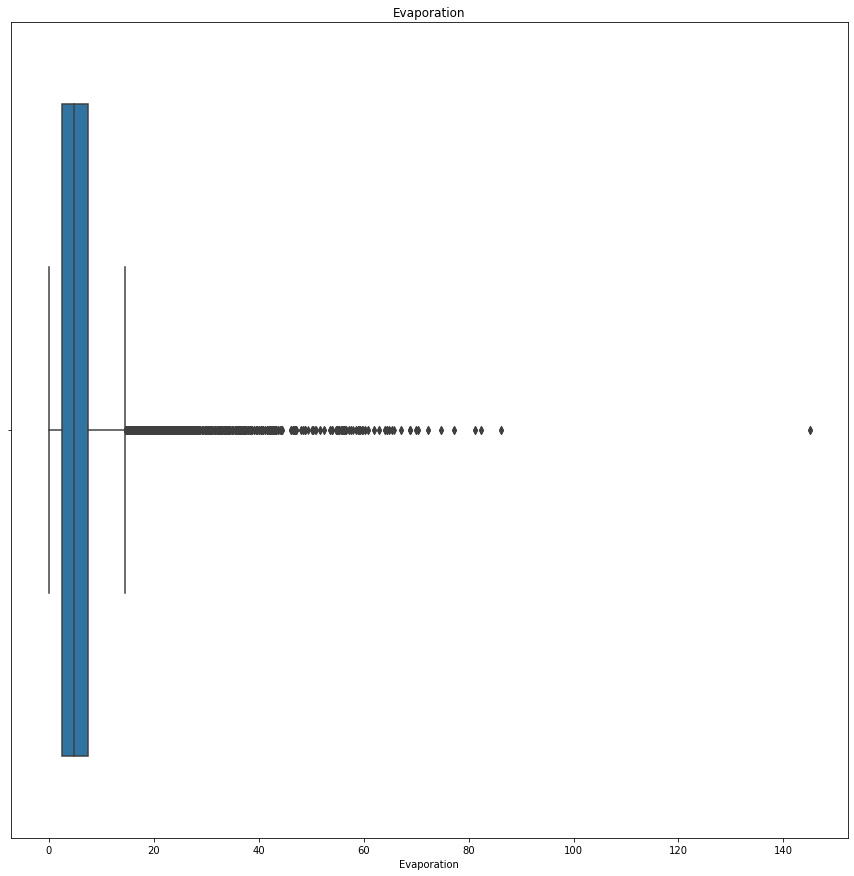

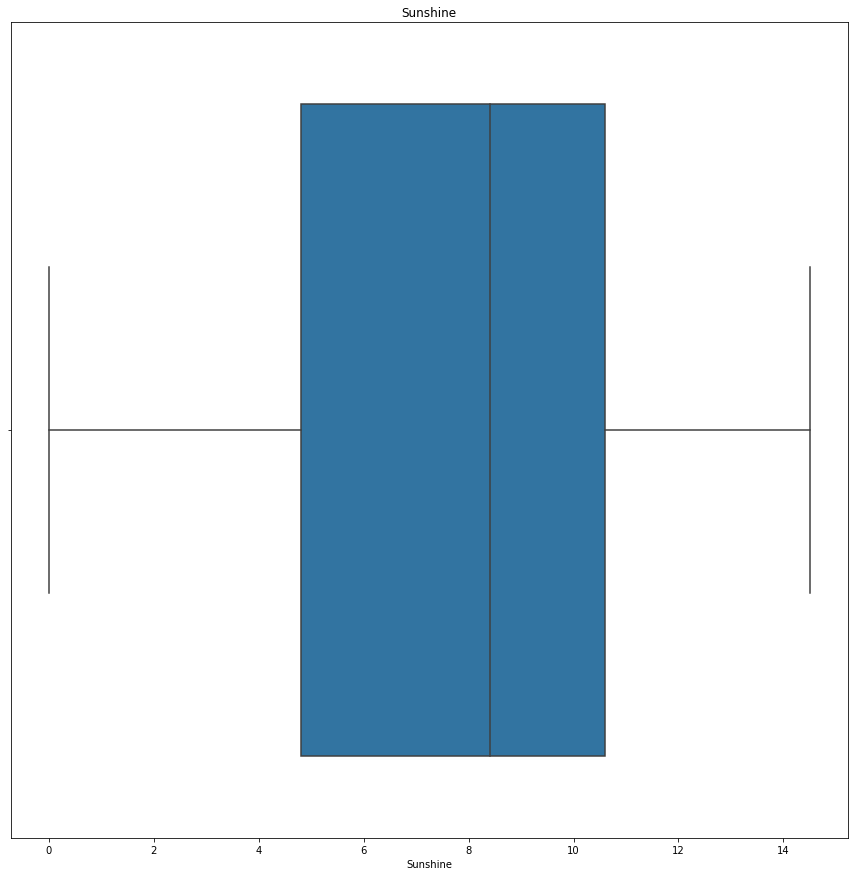

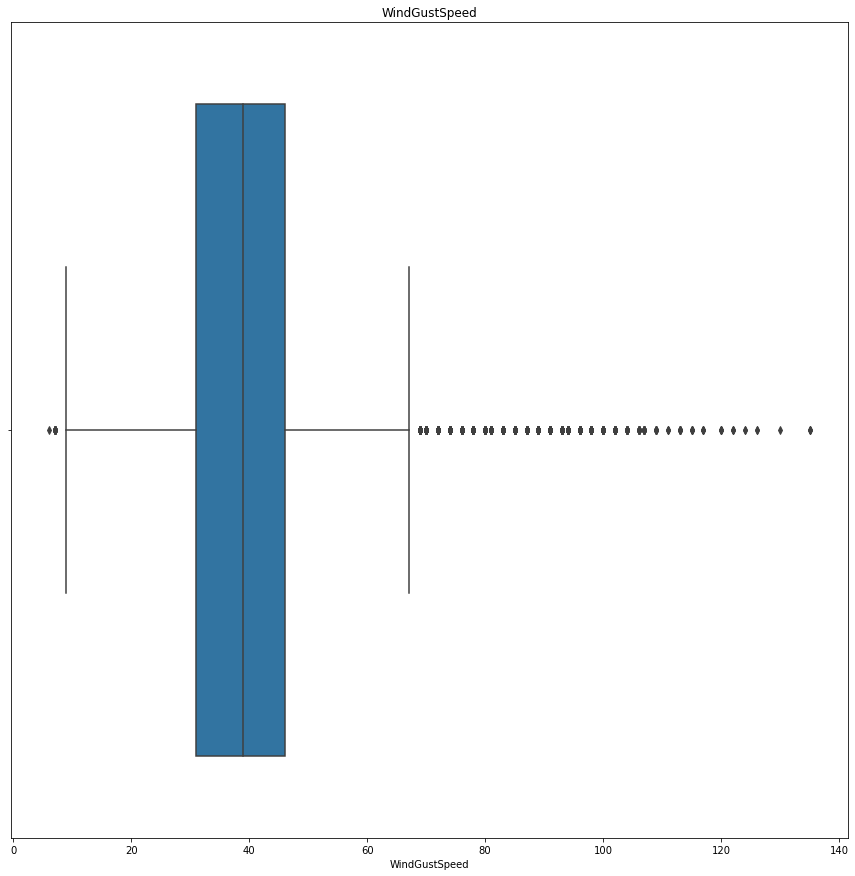

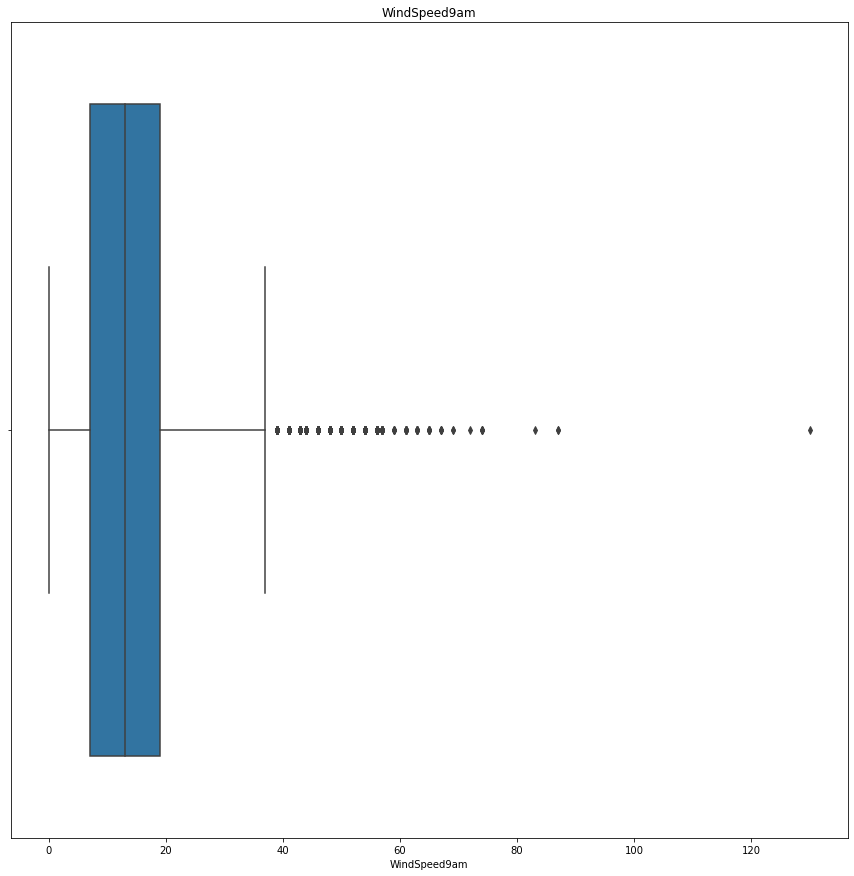

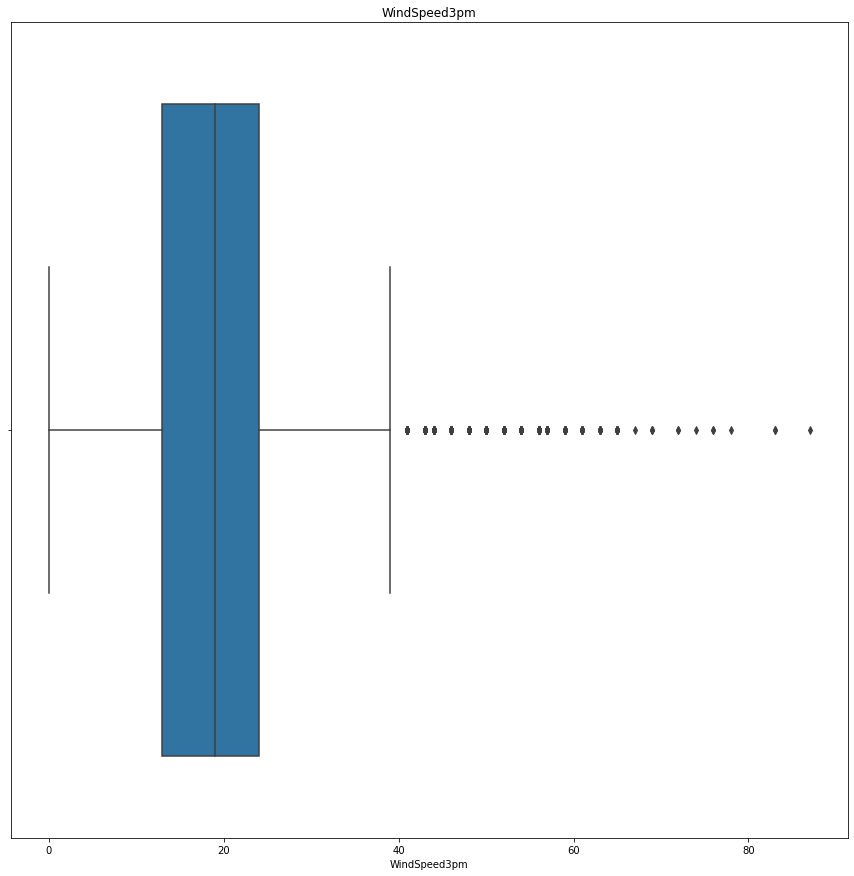

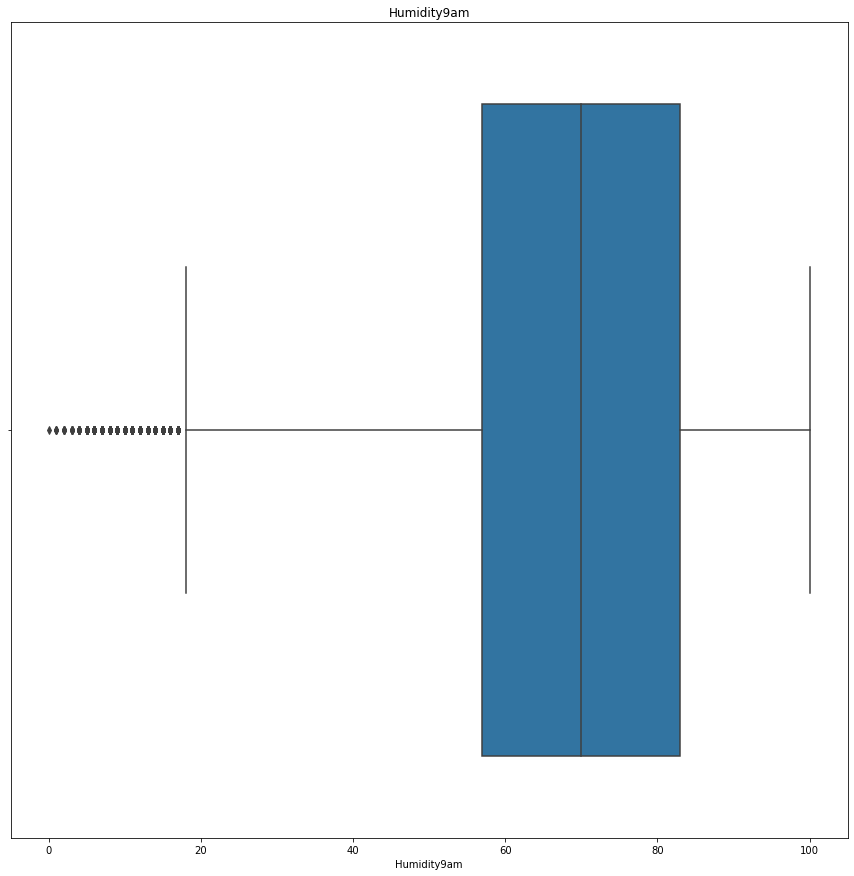

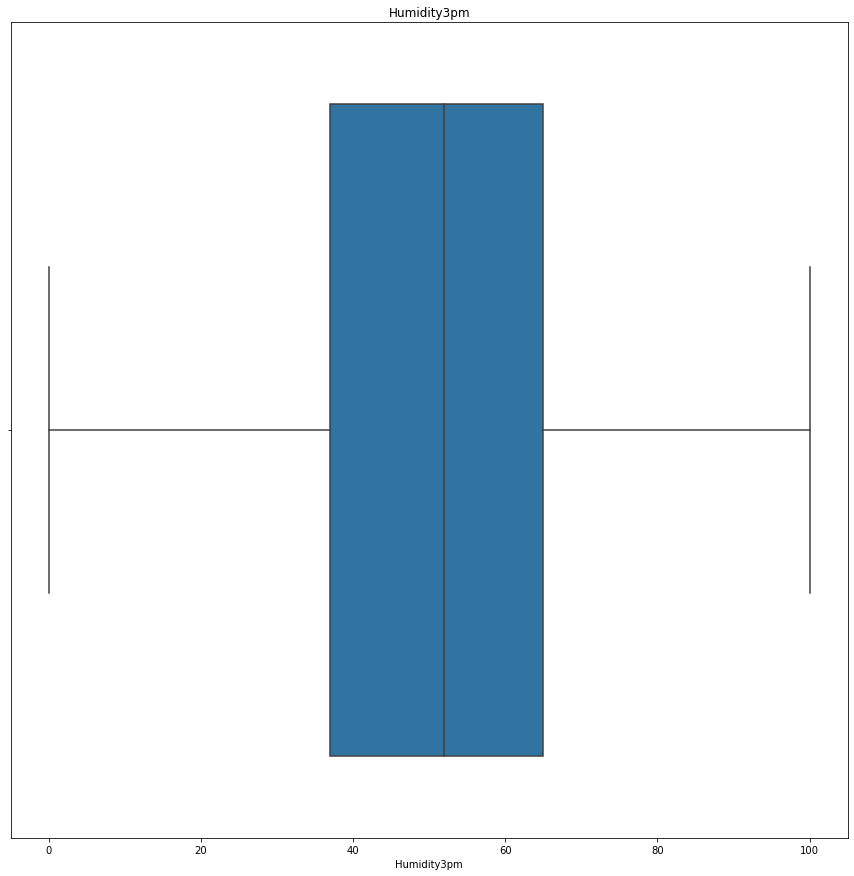

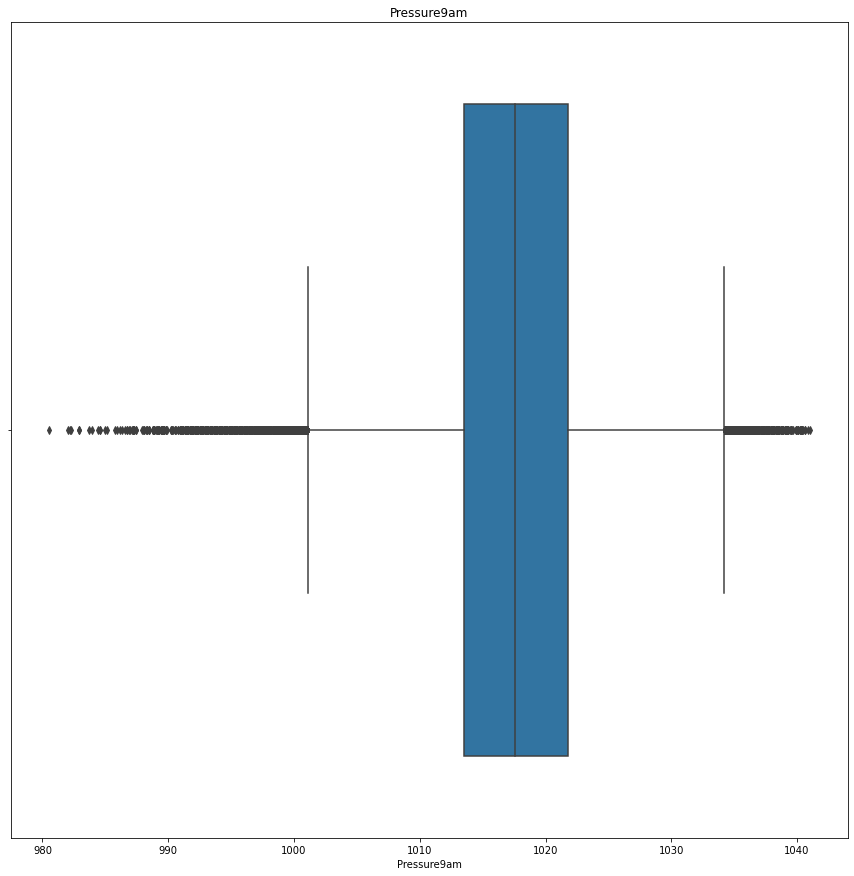

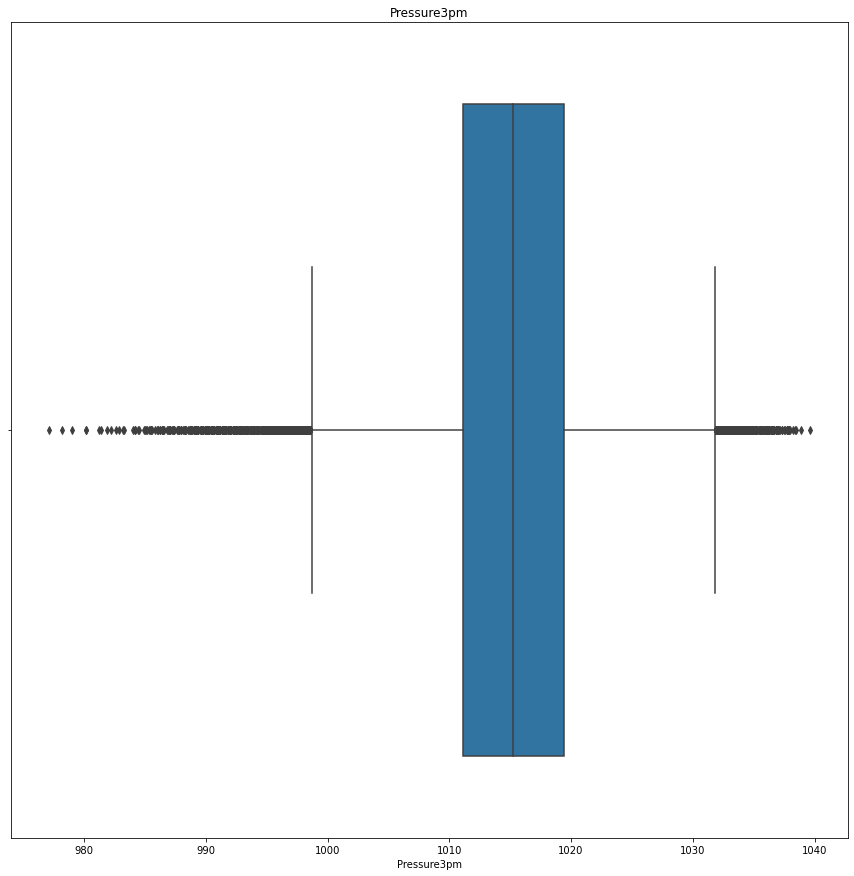

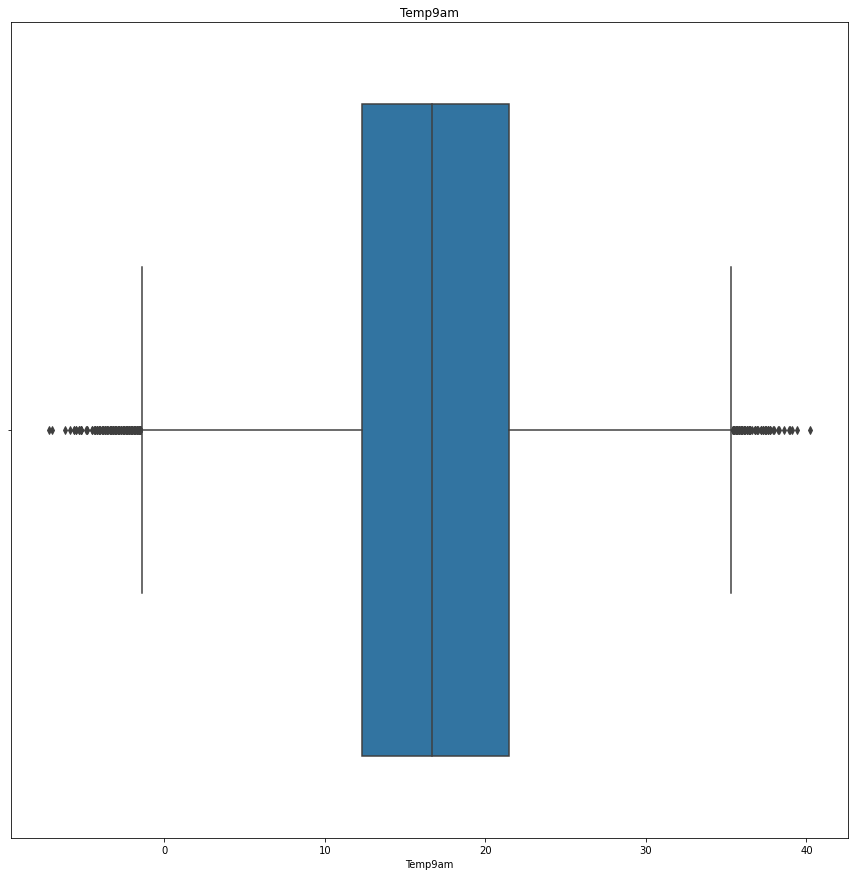

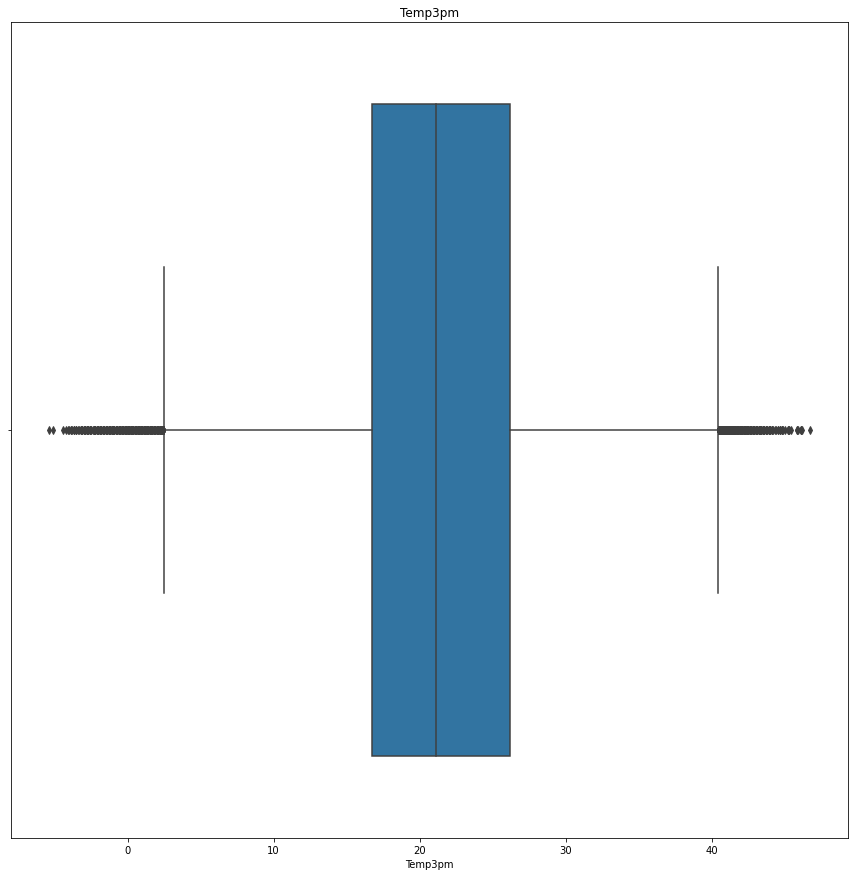

<Figure size 1080x1080 with 0 Axes>

In [131]:
# Plot the Box plot of the continous features to see the outliers in the features - values that lie outside the box limit


for feature in continuous_feature:
    datas=data.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

#### Almost all the continous features have outliers

Need to remove the outliers each continous feature separately

In [136]:
print(continuous_feature)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']


#### MinTemp

In [133]:
IQR=data.MinTemp.quantile(0.75)-data.MinTemp.quantile(0.25)
lower_bridge=data.MinTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=data.MinTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)    # Find the right and left limits

-5.950000000000002 30.450000000000003


In [138]:
data.loc[data['MinTemp']>=30.45,'MinTemp']=30.45 #Assign 30.45 (righ limit) to the points outside thr right limit
data.loc[data['MinTemp']<=-5.95,'MinTemp']=-5.95 #Assign -5.95 (left limit) to the points outside thr left limit

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1080x1080 with 0 Axes>

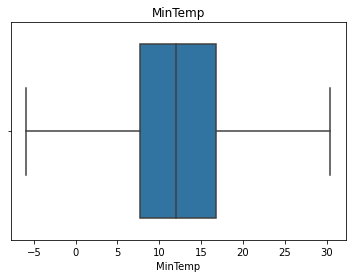

<Figure size 1080x1080 with 0 Axes>

In [140]:
datas=data.copy()
sns.boxplot(datas['MinTemp'])
plt.title('MinTemp')
plt.figure(figsize=(15,15))

#### Now we can see that the outlier points are removd from the feature 'Temp3pm'

#### Do the same for all the continous features one by one

In [141]:
IQR=data.MaxTemp.quantile(0.75)-data.MaxTemp.quantile(0.25)
lower_bridge=data.MaxTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=data.MaxTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

2.700000000000001 43.5


In [142]:
data.loc[data['MaxTemp']>=43.5,'MaxTemp']=43.5
data.loc[data['MaxTemp']<=2.7,'MaxTemp']=2.7

In [143]:
IQR=data.Rainfall.quantile(0.75)-data.Rainfall.quantile(0.25)
lower_bridge=data.Rainfall.quantile(0.25)-(IQR*1.5)
upper_bridge=data.Rainfall.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-0.8999999999999999 1.5


In [144]:
data.loc[data['Rainfall']>=1.5,'Rainfall']=1.5
data.loc[data['Rainfall']<=-0.89,'Rainfall']=-0.89

In [145]:
IQR=data.Evaporation.quantile(0.75)-data.Evaporation.quantile(0.25)
lower_bridge=data.Evaporation.quantile(0.25)-(IQR*1.5)
upper_bridge=data.Evaporation.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-4.600000000000001 14.600000000000001


In [146]:
data.loc[data['Evaporation']>=14.6,'Evaporation']=14.6
data.loc[data['Evaporation']<=-4.6,'Evaporation']=-4.6

In [147]:
IQR=data.WindGustSpeed.quantile(0.75)-data.WindGustSpeed.quantile(0.25)
lower_bridge=data.WindGustSpeed.quantile(0.25)-(IQR*1.5)
upper_bridge=data.WindGustSpeed.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

8.5 68.5


In [148]:
data.loc[data['WindGustSpeed']>=68.5,'WindGustSpeed']=68.5
data.loc[data['WindGustSpeed']<=8.5,'WindGustSpeed']=8.5

In [149]:
IQR=data.WindSpeed9am.quantile(0.75)-data.WindSpeed9am.quantile(0.25)
lower_bridge=data.WindSpeed9am.quantile(0.25)-(IQR*1.5)
upper_bridge=data.WindSpeed9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-11.0 37.0


In [150]:
data.loc[data['WindSpeed9am']>=37,'WindSpeed9am']=37
data.loc[data['WindSpeed9am']<=-11,'WindSpeed9am']=-11

In [151]:
IQR=data.WindSpeed3pm.quantile(0.75)-data.WindSpeed3pm.quantile(0.25)
lower_bridge=data.WindSpeed3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=data.WindSpeed3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-3.5 40.5


In [152]:
data.loc[data['WindSpeed3pm']>40.5,'WindSpeed3pm']=40.5
data.loc[data['WindSpeed3pm']<=-3.5,'WindSpeed3pm']=-3.5

In [153]:
IQR=data.Humidity9am.quantile(0.75)-data.Humidity9am.quantile(0.25)
lower_bridge=data.Humidity9am.quantile(0.25)-(IQR*1.5)
upper_bridge=data.Humidity9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

18.0 122.0


In [154]:
data.loc[data['Humidity9am']>=122,'Humidity9am']=122
data.loc[data['Humidity9am']<=18,'Humidity9am']=18

In [155]:
IQR=data.Pressure9am.quantile(0.75)-data.Pressure9am.quantile(0.25)
lower_bridge=data.Pressure9am.quantile(0.25)-(IQR*1.5)
upper_bridge=data.Pressure9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

1001.0500000000001 1034.25


In [156]:
data.loc[data['Pressure9am']>=1034.25,'Pressure9am']=1034.25
data.loc[data['Pressure9am']<=1001.05,'Pressure9am']=1001.05

In [157]:
IQR=data.Pressure3pm.quantile(0.75)-data.Pressure3pm.quantile(0.25)
lower_bridge=data.Pressure3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=data.Pressure3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

998.6500000000001 1031.85


In [158]:
data.loc[data['Pressure3pm']>=1031.85,'Pressure3pm']=1031.85
data.loc[data['Pressure3pm']<=998.65,'Pressure3pm']=998.65

In [159]:
IQR=data.Temp9am.quantile(0.75)-data.Temp9am.quantile(0.25)
lower_bridge=data.Temp9am.quantile(0.25)-(IQR*1.5)
upper_bridge=data.Temp9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-1.4999999999999982 35.3


In [160]:
data.loc[data['Temp9am']>=35.3,'Temp9am']=35.3
data.loc[data['Temp9am']<=-1.49,'Temp9am']=-1.49

In [161]:
IQR=data.Temp3pm.quantile(0.75)-data.Temp3pm.quantile(0.25)
lower_bridge=data.Temp3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=data.Temp3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

2.4499999999999993 40.45


In [162]:
data.loc[data['Temp3pm']>=40.45,'Temp3pm']=40.45
data.loc[data['Temp3pm']<=2.45,'Temp3pm']=2.45

### Now plot ath box plots of all the continous features again

/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/shamsudheen/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

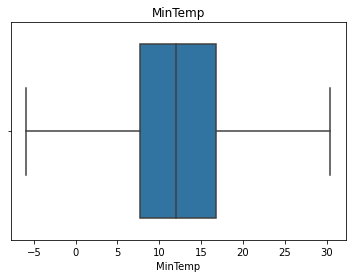

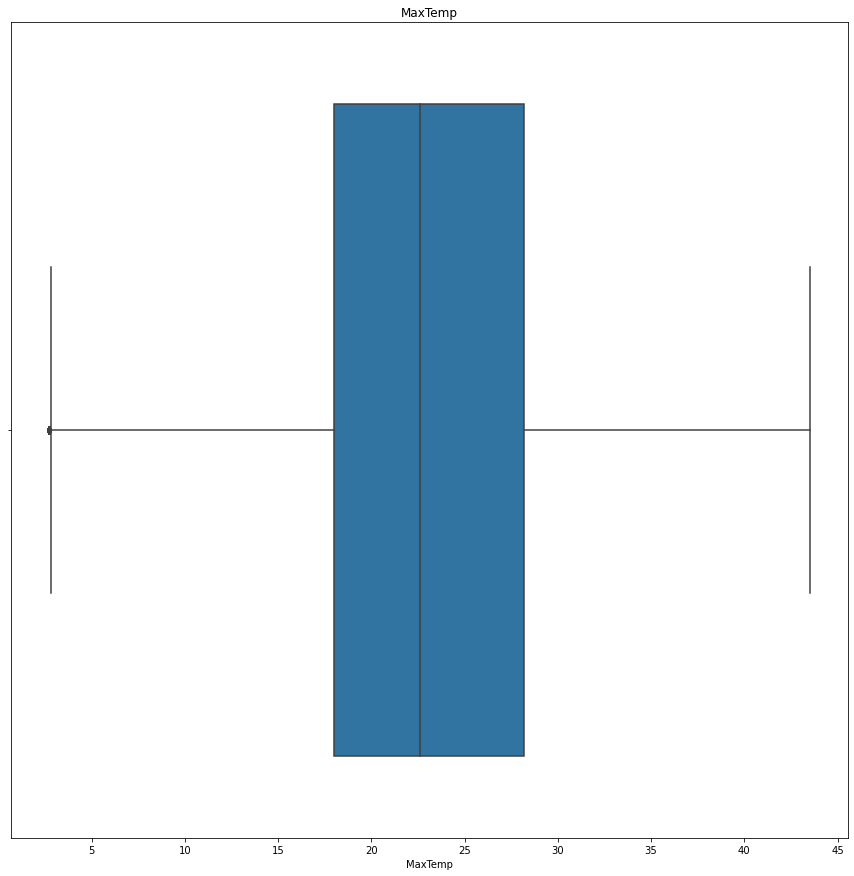

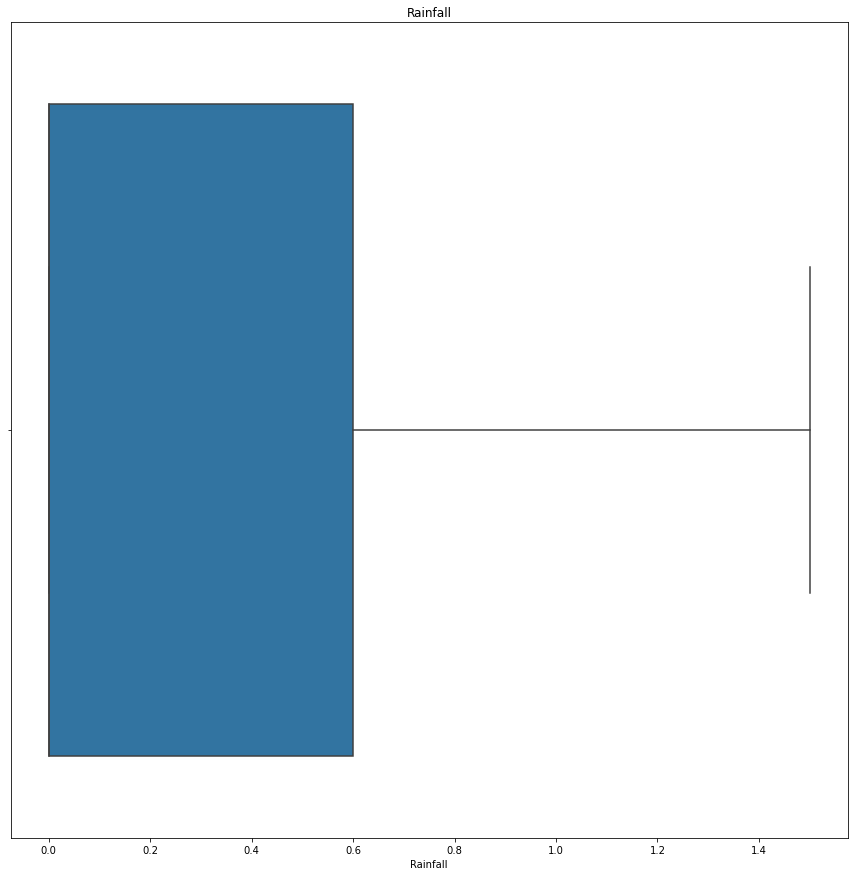

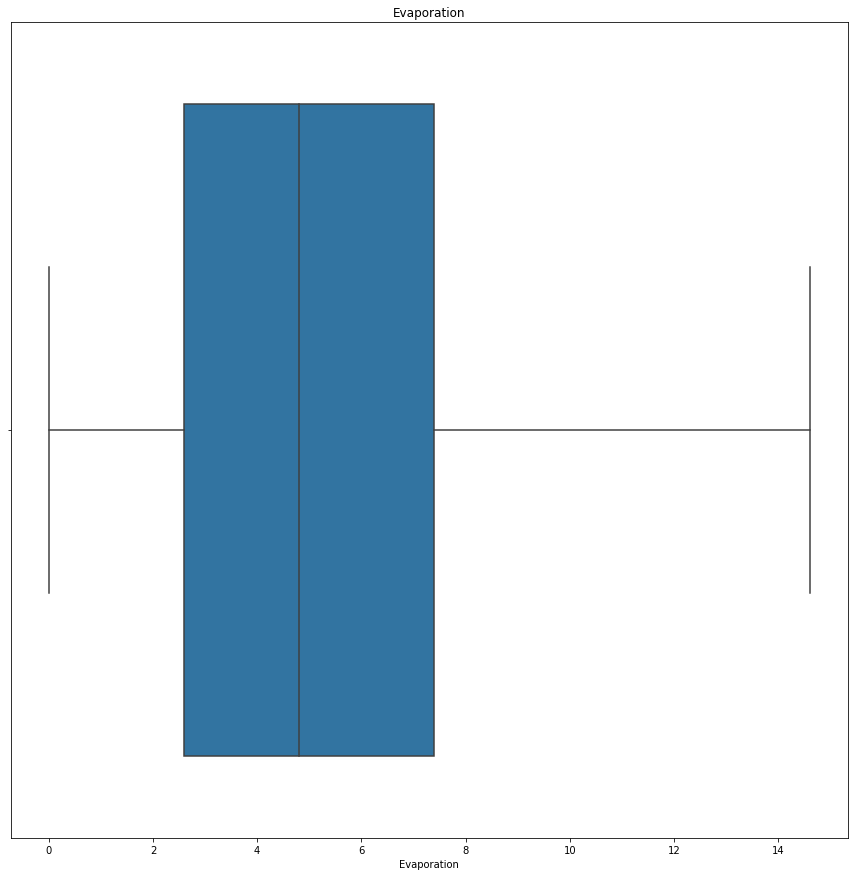

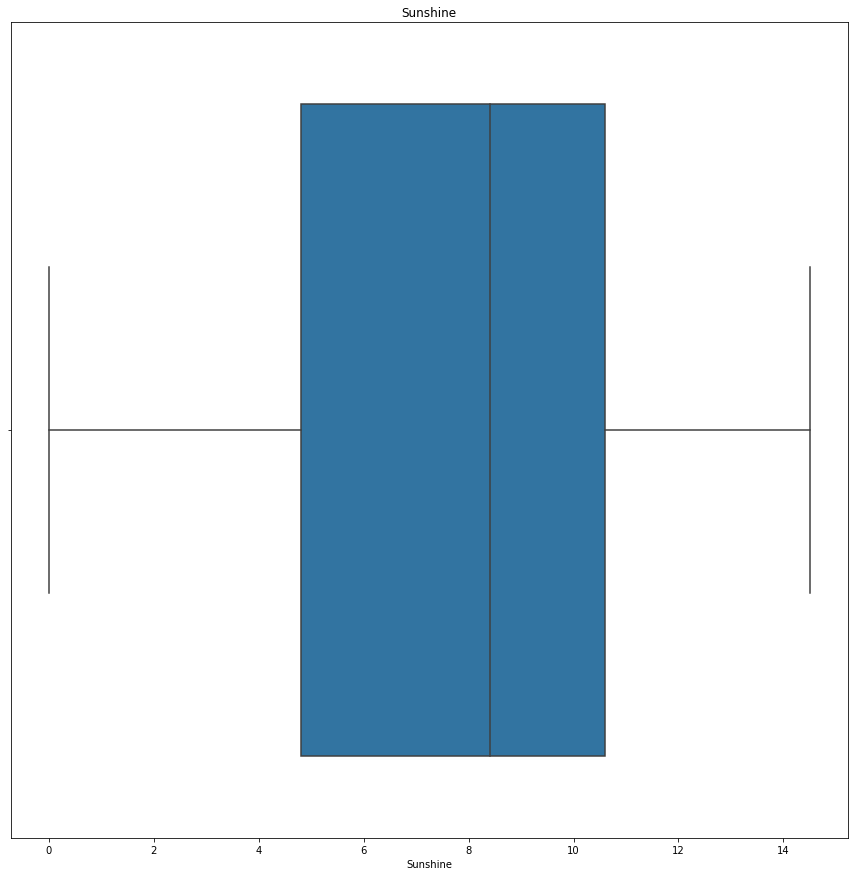

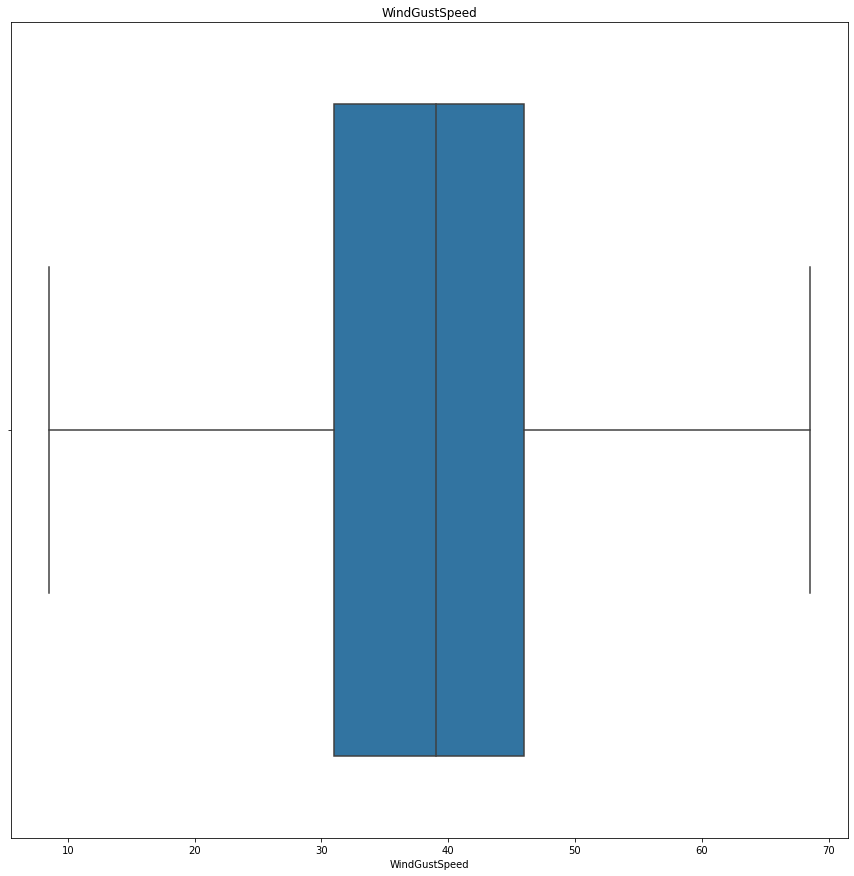

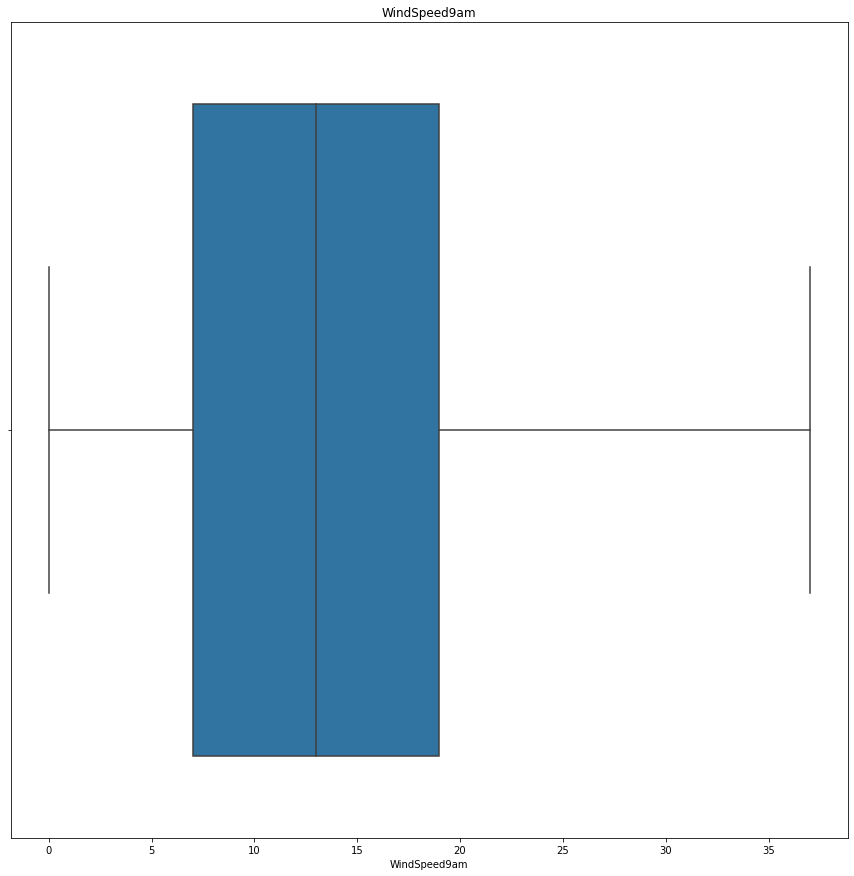

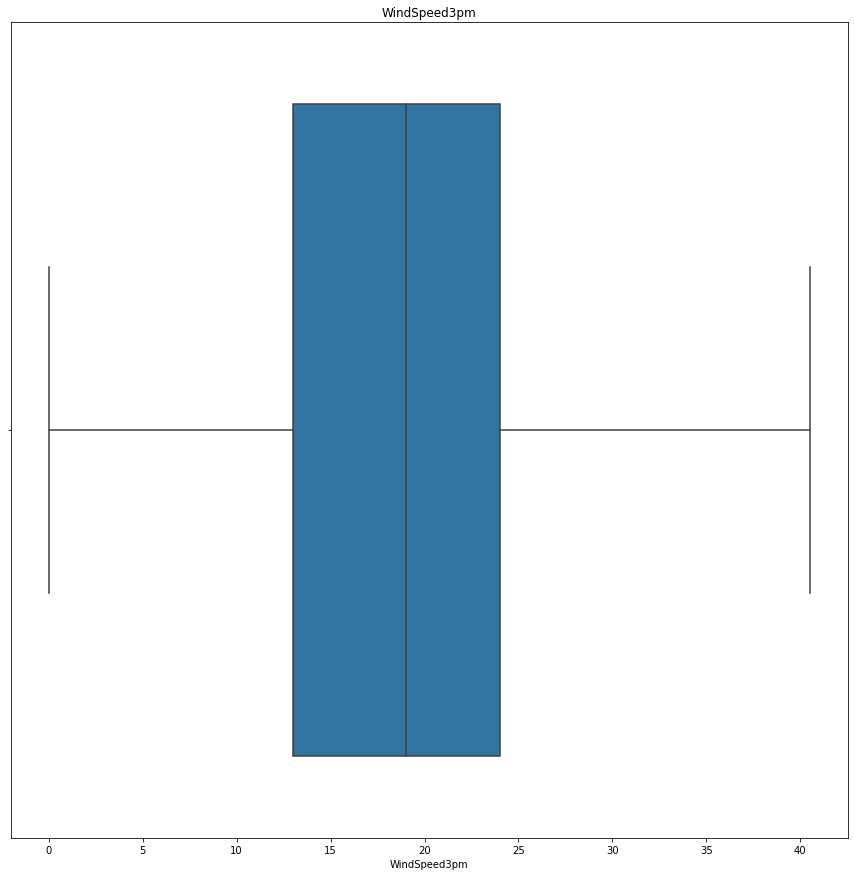

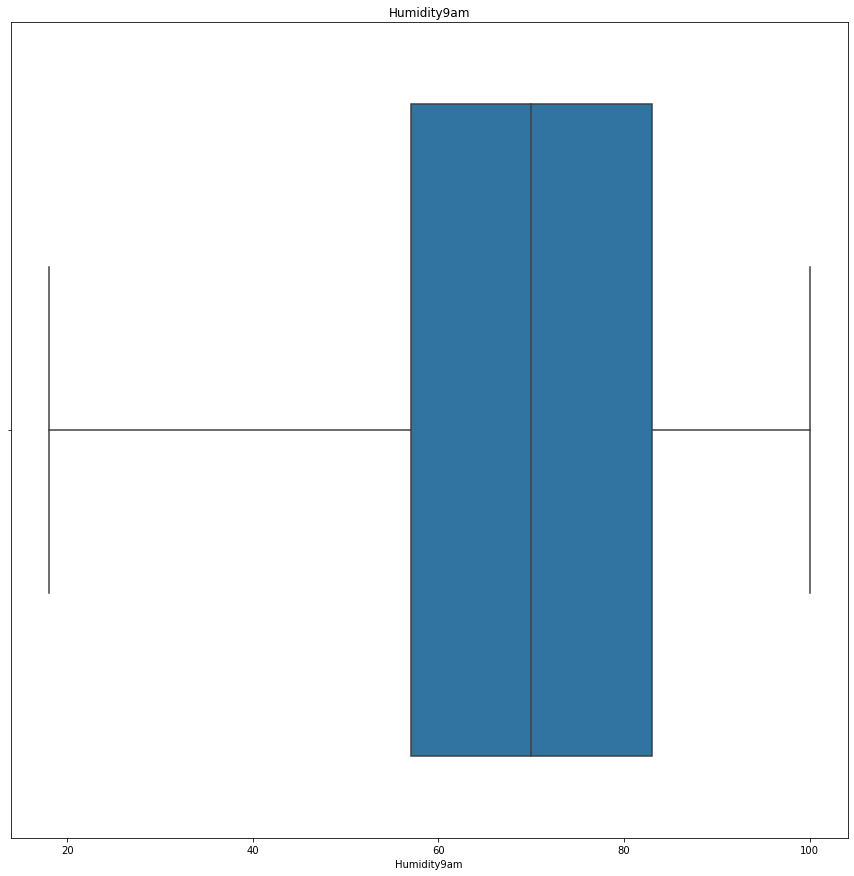

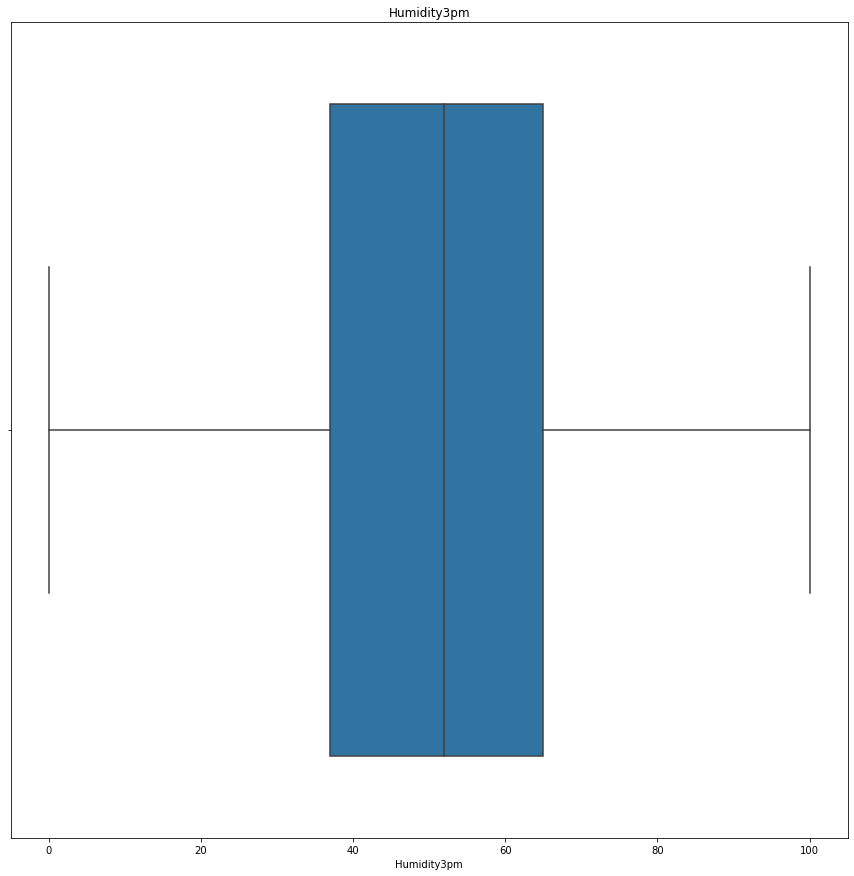

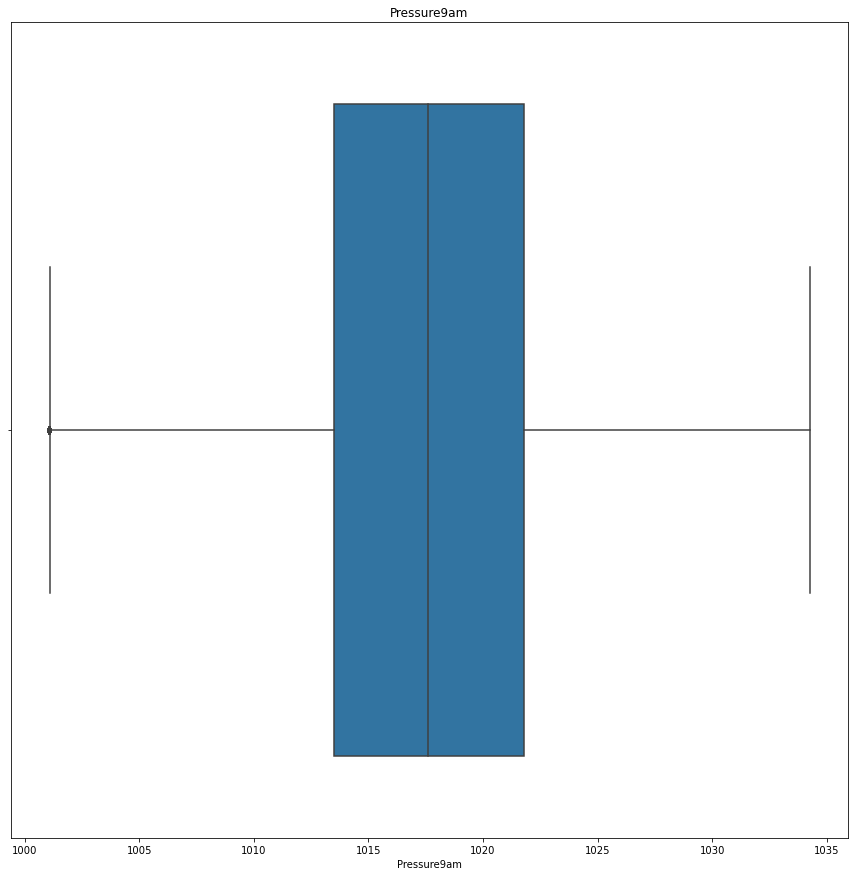

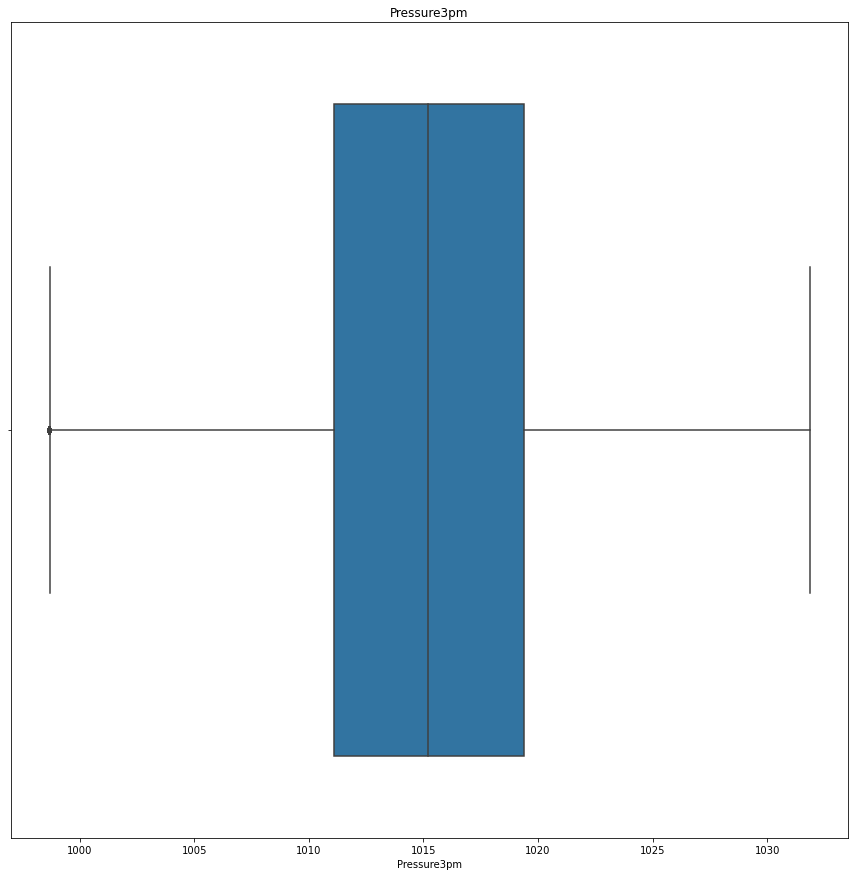

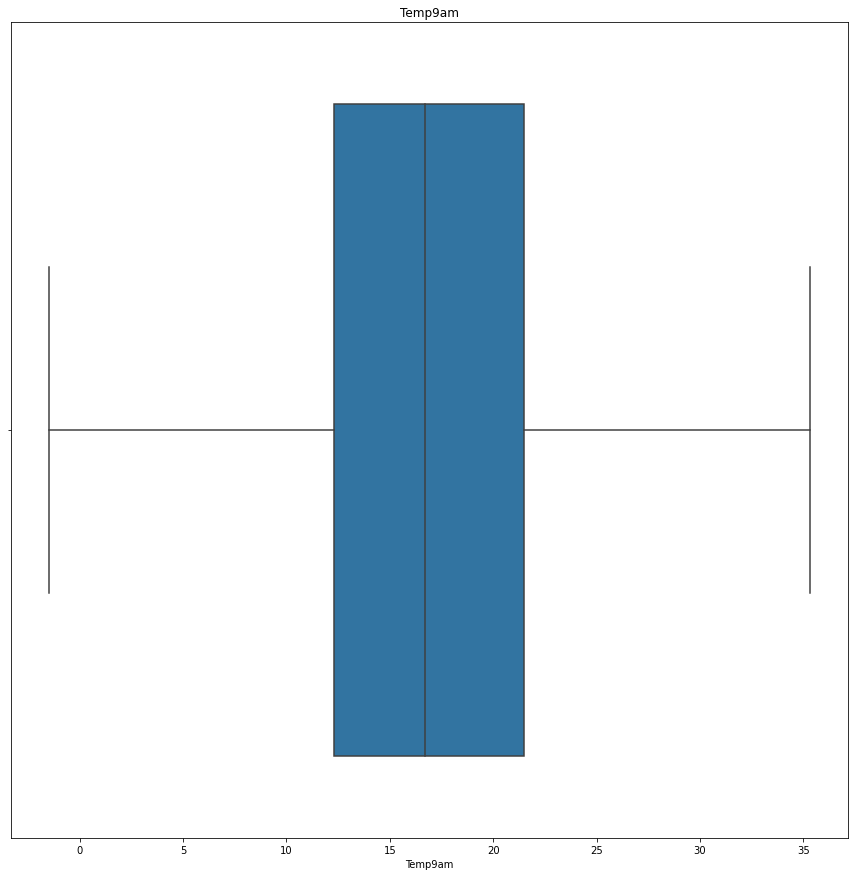

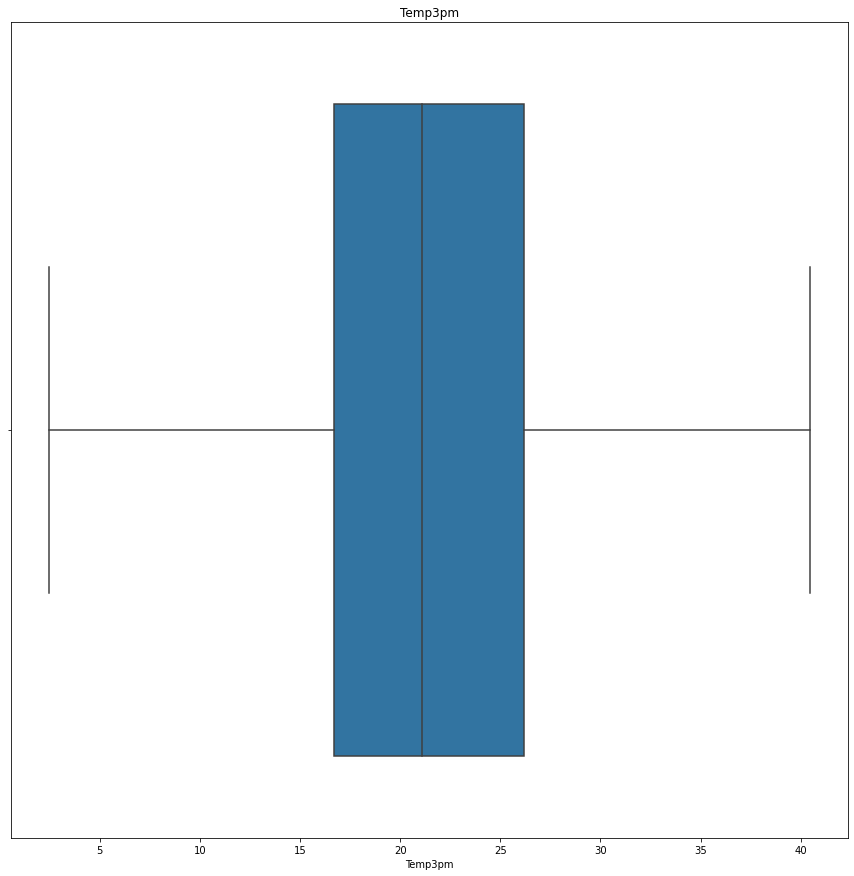

<Figure size 1080x1080 with 0 Axes>

In [163]:
for feature in continuous_feature:
    datas=data.copy()
    sns.boxplot(datas[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

### We can see that the outlier points are removed from all the features

### Now we can save this dataset as csv file

In [164]:
data.to_csv("preprocessed_1.csv", index=False)

## END